# 🧪 Group6_Project: California Google Local Business Analysis with PyMongo + Spark
This lab simulates a real-world big data pipeline using **MongoDB**, **PySpark**, and the **California Google Local Business Dataset**.
We'll:
- Insert data into MongoDB from JSON
- Load that data into Spark
- Perform analysis
- Save results back to MongoDB


## 📥 Step 1: Insert Google Local Data into MongoDB

In [1]:
import json
from pymongo import MongoClient
from pyspark.sql.functions import col

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]

# Drop old collections if they exist
db["meta"].drop()
db["review"].drop()

# === Trim and load only first 1000 businesses ===
with open("meta-California.json", "r", encoding="utf-8") as f:
    meta_data = [json.loads(line) for _, line in zip(range(1000), f)]
db["meta"].insert_many(meta_data)
print(f"✅ Inserted {len(meta_data)} meta")

# === Trim and load only first 5000 reviews ===
with open("review-California_10.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(5000), f)]
db["review"].insert_many(review_data)
print(f"✅ Inserted {len(review_data)} reviews")


✅ Inserted 1000 meta
✅ Inserted 5000 reviews


## ⚙️ Step 2: Start Spark Session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("group6_bigdata").getOrCreate()

## 📊 Step 3: Load Data

In [3]:
# assign typeValue for each feature of meta_dataset

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

schema_meta = StructType([
    StructField("name", StringType(), True),
    StructField("gmap_id", StringType(), True),
])


In [4]:
# assign typeValue for each feature of reviews_dataset
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType

schema_review = StructType([
    StructField("gmap_id", StringType(), True),
    StructField("rating", IntegerType(), True),
    StructField("text", StringType(), True),
])


In [5]:
import re
def safe_str(x, max_length=200):
    try:
        s = str(x)
        s = re.sub(r"[^\x00-\x7F]+", "", s)
        return s[:max_length]
    except:
        return ""

In [6]:
#clean data in the case data has multiple types

# for meta_dataset
def clean_meta_doc(doc):

    return {
        "name": safe_str(doc.get("name", None)),
        "gmap_id": safe_str(doc.get("gmap_id", None)),
    }


In [7]:
# for reviews_dataset
def clean_review_doc(doc):
    
    def to_int(val):
        try:
            return int(val)
        except (TypeError, ValueError):
            return None

    return {
        "gmap_id": doc.get("gmap_id", None),  # Use None for missing values
        "rating": to_int(doc.get("rating", 0)),
        "text": safe_str(doc.get("text", None)),
    }


In [8]:
from pyspark.sql.functions import col

meta_docs = list(db["meta"].find({}, {"_id": 0}))
cleaned_meta_docs = [clean_meta_doc(doc) for doc in meta_docs]
df_meta = spark.createDataFrame(cleaned_meta_docs, schema=schema_meta)
df_meta = df_meta.withColumnRenamed("name", "business_name")
df_meta.show(3, truncate=False)


+-------------+-------------------------------------+
|business_name|gmap_id                              |
+-------------+-------------------------------------+
|City Textile |0x80c2c98c0e3c16fd:0x29ec8a728764fdf9|
|San Soo Dang |0x80c2c778e3b73d33:0xbdc58662a4a97d49|
|Nova Fabrics |0x80c2c89923b27a41:0x32041559418d447 |
+-------------+-------------------------------------+
only showing top 3 rows



In [9]:
from pyspark.sql.functions import col

review_docs = list(db["review"].find({}, {"_id": 0}))
cleaned_review_docs = [clean_review_doc(doc) for doc in review_docs]
df_review = spark.createDataFrame(cleaned_review_docs, schema=schema_review)
df_review.show(3, truncate=True)

+--------------------+------+--------------------+
|             gmap_id|rating|                text|
+--------------------+------+--------------------+
|0x80c2c778e3b73d3...|     5|Love there korean...|
|0x80c2c778e3b73d3...|     5|      Good very good|
|0x80c2c778e3b73d3...|     4|They make Korean ...|
+--------------------+------+--------------------+
only showing top 3 rows



## 🔎 Step 4: Join and Analyze in Spark

In [10]:
from pyspark.sql.functions import col
df_joined = df_meta.join(df_review, on="gmap_id", how="inner")
df_joined.show(3, truncate=True)

+--------------------+----------------+------+--------------------+
|             gmap_id|   business_name|rating|                text|
+--------------------+----------------+------+--------------------+
|0x80dd33844146872...|HAVEN Dispensary|     2|The entire proces...|
|0x80dd33844146872...|HAVEN Dispensary|     5|Often the Haven t...|
|0x80dd33844146872...|HAVEN Dispensary|     5|I ordered the nig...|
+--------------------+----------------+------+--------------------+
only showing top 3 rows



In [11]:
# cache the DataFrame to optimize performance.
df_joined = df_joined.cache()
df_joined.count()

4981

In [12]:
# Calculate the average rating and the top 10 businesses

from pyspark.sql.functions import avg, count

df_avg = df_joined.groupBy("gmap_id", "business_name") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("review_count")
    ) \
    .orderBy("avg_rating", ascending=False)

top10 = df_avg.limit(10).collect()
print(top10)

[Row(gmap_id='0x80c2c6594138441d:0x59088f7293270c3f', business_name='Widows Peak Salon', avg_rating=5.0, review_count=7), Row(gmap_id='0x80c2d79e7b47971d:0x14d7458d6fc5e435', business_name='New Life Baptist Church of Los Angeles', avg_rating=5.0, review_count=5), Row(gmap_id='0x80c2c679fbbc2825:0x8cac9f2a2e5011cd', business_name='Pipil Print', avg_rating=5.0, review_count=5), Row(gmap_id='0x80857e87e931a1ef:0x3cf68574eca52159', business_name='iPlayNtalk iPhone Repair', avg_rating=5.0, review_count=5), Row(gmap_id='0x80dcde96809ca927:0x9ba5b9ae5526f1fc', business_name='St John Knits International Inc', avg_rating=5.0, review_count=5), Row(gmap_id='0x80ea13b97154b5bf:0xe75a082e10573b3', business_name='CARKING', avg_rating=5.0, review_count=7), Row(gmap_id='0x80c3524d2a235f37:0x476df59c77864415', business_name='Hoffman Furniture Repair and Refinishing', avg_rating=5.0, review_count=10), Row(gmap_id='0x80c29c3931a168c5:0x5b11945dbec5d83f', business_name='D&D Electrical Services, Inc.', avg

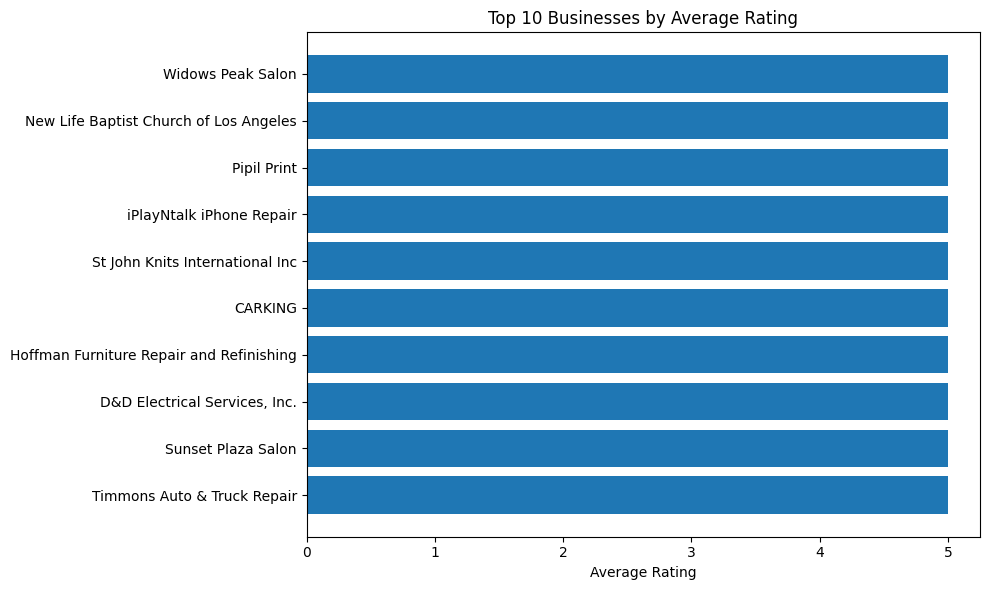

In [13]:
import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10]
ratings = [row["avg_rating"] for row in top10]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], ratings[::-1])
plt.xlabel("Average Rating")
plt.title("Top 10 Businesses by Average Rating")
plt.tight_layout()
plt.show()

In [14]:
# Calculate the most reviewed businesses

from pyspark.sql.functions import count

df_most_reviewed = df_joined.groupBy("gmap_id", "business_name") \
    .agg(count("rating").alias("review_count")) \
    .orderBy("review_count", ascending=False)

top10_most_reviewed = df_most_reviewed.limit(10).collect()
print(top10_most_reviewed)

[Row(gmap_id='0x80c2d64099488c43:0xc53414053ea23f1c', business_name='Tortilleria La Pequenita', review_count=52), Row(gmap_id='0x80ec6b5fdfb87849:0xa35fd3a6865cb981', business_name="Beverly's Fabric & Crafts", review_count=51), Row(gmap_id='0x80dcd5d53b8f5495:0x4695110eb6279e5b', business_name='Twins Chiropractic', review_count=51), Row(gmap_id='0x80c352e78d0640d1:0xea59afd41029a39d', business_name='Ruben Campos Community Center', review_count=48), Row(gmap_id='0x80926d56eecd313b:0xcbc57657050694f1', business_name='Gonzales Union High School Stadium', review_count=46), Row(gmap_id='0x80ea6a2c73eaee49:0xe01abb12b7facc13', business_name='AAMCO Transmissions & Total Car Care', review_count=38), Row(gmap_id='0x80d953c0d67f5785:0x9018208e3e55bf7b', business_name='Phantastic Nails & Spa', review_count=37), Row(gmap_id='0x809053c2c4933c67:0x3bb6193adf4ee342', business_name='Anthonys Barber Shop', review_count=36), Row(gmap_id='0x808df9391c67d2df:0xf71cedc4ae428c81', business_name='Mobil', rev

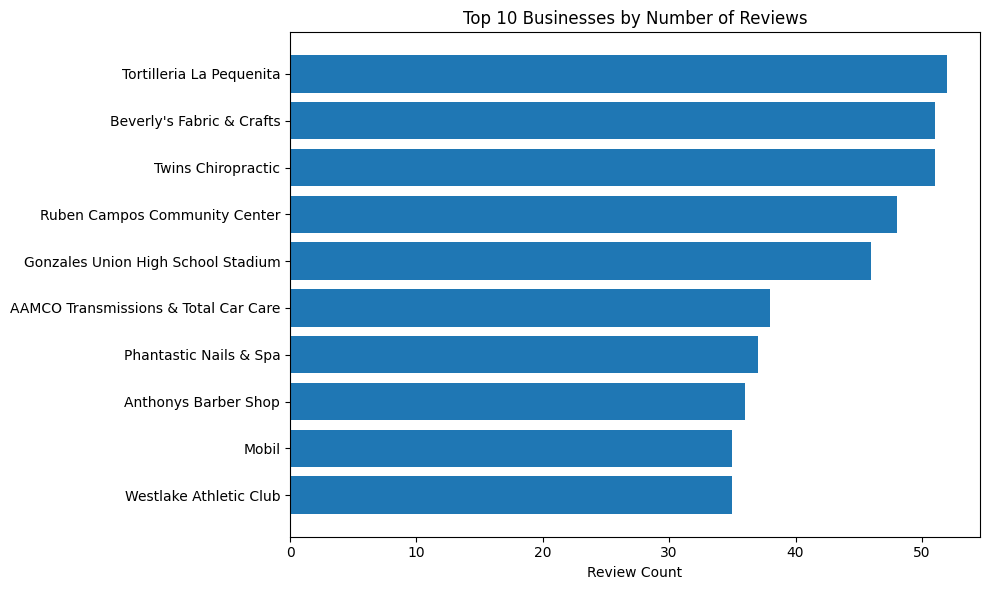

In [15]:
import matplotlib.pyplot as plt

names = [row["business_name"] for row in top10_most_reviewed]
counts = [row["review_count"] for row in top10_most_reviewed]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], counts[::-1])
plt.xlabel("Review Count")
plt.title("Top 10 Businesses by Number of Reviews")
plt.tight_layout()
plt.show()

In [16]:
# Calculate the distribution of ratings

from pyspark.sql.functions import when, count

df_buckets = df_joined.select("rating").withColumn(
    "rating_bucket",
    when((col("rating") >= 1) & (col("rating") < 2), "1-2")
    .when((col("rating") >= 2) & (col("rating") < 3), "2-3")
    .when((col("rating") >= 3) & (col("rating") < 4), "3-4")
    .when((col("rating") >= 4) & (col("rating") <= 5), "4-5")
    .otherwise("invalid")
)

df_bucket_count = df_buckets.groupBy("rating_bucket").agg(count("*").alias("count"))

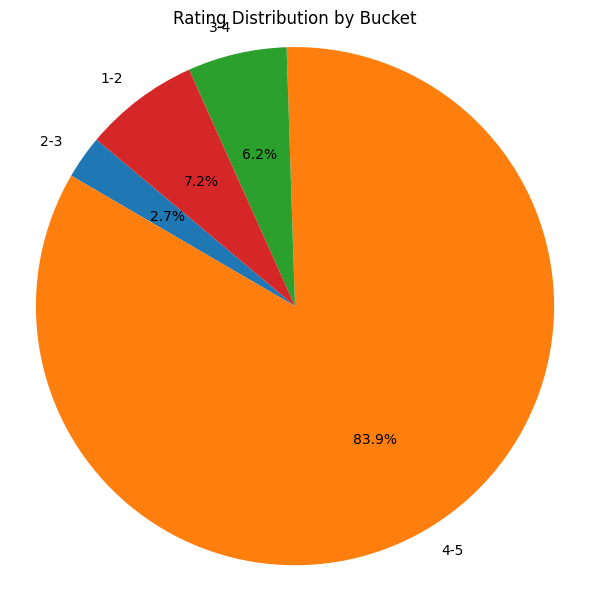

In [17]:
bucket_data = df_bucket_count.collect()

labels = [row["rating_bucket"] for row in bucket_data]
sizes = [row["count"] for row in bucket_data]

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Rating Distribution by Bucket")
plt.axis("equal")
plt.tight_layout()
plt.show()

## 💾 Step 5: Save Top Businesses Back to MongoDB

In [18]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "avg_rating": float(row["avg_rating"]),
    }
    for row in top10
]

from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_avg_rating"].drop()
db["top10_avg_rating"].insert_many(top10_dicts)

InsertManyResult([ObjectId('67f82fb1eff669e866a5857f'), ObjectId('67f82fb1eff669e866a58580'), ObjectId('67f82fb1eff669e866a58581'), ObjectId('67f82fb1eff669e866a58582'), ObjectId('67f82fb1eff669e866a58583'), ObjectId('67f82fb1eff669e866a58584'), ObjectId('67f82fb1eff669e866a58585'), ObjectId('67f82fb1eff669e866a58586'), ObjectId('67f82fb1eff669e866a58587'), ObjectId('67f82fb1eff669e866a58588')], acknowledged=True)

In [19]:
top10_dicts = [
    {
        "gmap_id": row["gmap_id"],
        "business_name": row["business_name"],
        "review_count": int(row["review_count"]),
    }
    for row in top10_most_reviewed
]

from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["group6_bigdata"]
db["top10_review_count"].drop()
db["top10_review_count"].insert_many(top10_dicts)


InsertManyResult([ObjectId('67f82fb1eff669e866a5858a'), ObjectId('67f82fb1eff669e866a5858b'), ObjectId('67f82fb1eff669e866a5858c'), ObjectId('67f82fb1eff669e866a5858d'), ObjectId('67f82fb1eff669e866a5858e'), ObjectId('67f82fb1eff669e866a5858f'), ObjectId('67f82fb1eff669e866a58590'), ObjectId('67f82fb1eff669e866a58591'), ObjectId('67f82fb1eff669e866a58592'), ObjectId('67f82fb1eff669e866a58593')], acknowledged=True)

In [20]:
docs = [
    {
        "bucket": row["rating_bucket"],
        "count": int(row["count"]),
    }
    for row in bucket_data
]

db["rating_distribution"].drop()
db["rating_distribution"].insert_many(docs)

InsertManyResult([ObjectId('67f82fb1eff669e866a58594'), ObjectId('67f82fb1eff669e866a58595'), ObjectId('67f82fb1eff669e866a58596'), ObjectId('67f82fb1eff669e866a58597')], acknowledged=True)

## ✅ Summary
- We ingested real-world JSON data into MongoDB
- Processed it in Spark
- Wrote back results to MongoDB
- This simulates your final project in a smaller scope 🚀